All files in MUSDB18 dataset is a multitrack format composed of 5 stereo streams, each one encoded in AAC @256kbps. These signals correspond to:

- `0` - The mixture,
- `1` - The drums,
- `2` - The bass,
- `3` - The rest of the accompaniment,
- `4` - The vocals.

```S.shape = (5, time_step , 2)```



## Début des fonctions utiles

In [2]:
import IPython.display as ipd
from  IPython.display import display
import librosa
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import stempeg
import itertools
import operator
import soundfile
import pyroomacoustics as pra
from numpy import typing
from mir_eval.separation import bss_eval_sources
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)

path_in = './train/'

In [3]:
files_in = []
files_title = []

# extract files 
for r, d, f in os.walk(path_in):
    for file in f:
        if '.mp4' in file:

            # file address
            files_in.append(os.path.join(r, file))
            # file author + song
            files_title.append(file[:-9])
            
files_in.sort()

#### Fonction de création de salle

In [4]:
def shoebox_recording(
    room_dimension, 
    abs_coef, 
    microphone_locations,
    microphone_dir = None,
    rate = 44100,
    display_room = False,
    ):

    """ 
    
    this function creates a shoebox room (defined 
    with its geometry, room absorption, source 
    locations and microphones locations)

    Input
    ---
    - room_dimension:       Array [length, width, height]   = room dimensions
    - abs_coef:             float                           = Sabine absorbtion coefficient
    - microphone_locations: np.c_ [[3D locations],...]      = microphones locations
    - microphone_dir:       optionnal, directivity          = microphones directivity
    - rate:                 optionnal, int                  = rate of the microphone (44100 default)
    - display_room:         optionnal, bool                 = room display (False default)

    Output
    ---

    - room:                 ShoeBox                         = room

    """

    # Create an shoebox room
    room = pra.ShoeBox(room_dimension, fs=rate, max_order=15, absorption=abs_coef, sigma2_awgn=1e-8)

    # Add microphone array
    mic_array = pra.MicrophoneArray(microphone_locations, rate)
    room.add_microphone_array(mic_array, directivity=microphone_dir)
    
    if display_room:
        fig, ax = room.plot()
        lim = 9
        ax.set_xlim([0, lim])
        ax.set_ylim([0, lim])
        ax.set_zlim([0, lim])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    return room

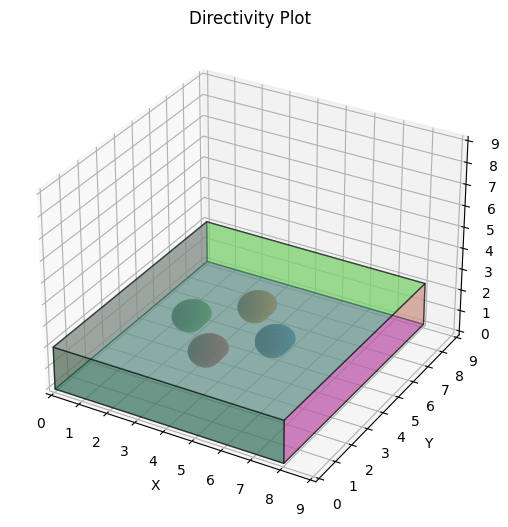

In [5]:
mic_pattern = DirectivityPattern.CARDIOID
MIC_DIR = CardioidFamily(
    orientation = DirectionVector(azimuth=180, colatitude=60, degrees=True),
    pattern_enum = mic_pattern,
)
room_dimension = [8, 9, 2]
abs_coef = 0.35
source_locations = [[6, 4.5, 1], [4, 6.5, 1], [2, 4.5, 1], [4, 2.5, 1]]
microphone_locations = np.c_[[5.5, 4.5, 1], [4, 6, 1], [2.5, 4.5, 1], [4, 3, 1]]
song_path = files_in[0]


shoebox_room = shoebox_recording(room_dimension, abs_coef, microphone_locations, microphone_dir=MIC_DIR, display_room=True)

#### Fonction pour les spectrogrammes

In [6]:
def room_spectrogram_from_musdb(
    room,
    source_locations,
    source_dir,
    song_path,
    audio_length,
    L=2048,
    hop=512,
    rate = 44100, 
    display_audio = False,
    ):

    """ 
    
    this function process a song from MUSDB18 dataset
    as a recording in a shoebox room (defined with its 
    geometry, room absorption, signal locations and 
    microphones locations) into a multichannel STFT.

    Input
    ---
    - room:                 room                                = room dimensions
    - source_locations:     Array [[3D locations],...]          = source locations
    - source_dir:           optionnal, directivity              = source directivity (None default)
    - song_path:            int                                 = number of the song
    - audio_length:         int                                 = length in second
    - L:                    optionnal, int                      = frame size (2048 default)
    - hop:                  optionnal, int                      = hop length (512 default)
    - rate:                 optionnal, int                      = signal rate (44100 default)
    - display_audio:        optionnal, bool                     = audio display (False default)

    Output
    ---

    - X:                    Array [4 x frequency x time_step]   = multichannel spectogram of the song
    - separate recordings:  Array [4 x 4 x time_step]           = recordings of each channel on each microphone separately
    - mics signals:         Array [4 x time_step]               = recordings of each microphones

    """
    path = song_path
    data, rate = stempeg.read_stems(path)
    channel_nb, time_step, _ = data.shape
    X = []

    # Add sources
    for channel_source, source_loc in zip(range(1,len(data)), source_locations):
        signal_channel = librosa.core.to_mono(data[channel_source, :rate*audio_length, :].T)
        room.add_source(position = source_loc, directivity = source_dir, signal=signal_channel)

    # Recordings
    separate_recordings = room.simulate(return_premix=True)
    mics_signals = np.sum(separate_recordings, axis=0)
    
    # STFT parameters
    win_a = pra.hamming(L)
    win_s = pra.transform.stft.compute_synthesis_window(win_a, hop)
          
    # Observation vector in the STFT domain
    for channel in range(channel_nb - 1):

        Xn = pra.transform.stft.analysis(mics_signals[channel].T, L, hop, win=win_a)
        X.append(Xn)

    X = np.array(X)

    if display_audio:
        for microphone_n in range(channel_nb - 1) :
            display(ipd.Audio(mics_signals[microphone_n], rate=room.fs))

    return X, separate_recordings, mics_signals

In [7]:
source_locations = [[6, 4.5, 1], [4, 6.5, 1], [2, 4.5, 1], [4, 2.5, 1]]
source_dir = None
song_path = files_in[0]


X, separate_recordings, mics_signals = room_spectrogram_from_musdb(shoebox_room, source_locations, source_dir, song_path, audio_length=10, L=2048, hop=512, display_audio=True)